# MAPS Summer School – LISA Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vincnardelli/maps/blob/main/Python/notebooks/1_lisa_colab.ipynb)

**Data loads automatically from GitHub**

In [1]:
import os
import sys
# Download shapefile data from GitHub
import urllib.request
os.makedirs('data', exist_ok=True)

base_url = 'https://github.com/vincnardelli/maps/raw/main/data/sdr_subnational_data_migration/shps/sdr_subnational_data_dhs_2022_lvl_2'
extensions = ['.shp', '.shx', '.dbf', '.prj']

print('📥 Downloading data from GitHub...')
for ext in extensions:
    url = base_url + ext
    filename = f'data/sdr_subnational_data_dhs_2022_lvl_2{ext}'
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
        print(f'  ✓ {ext}')
    else:
        print(f'  ⊙ {ext} (cached)')

DATA_PATH = 'data/sdr_subnational_data_dhs_2022_lvl_2.shp'
print(f'\n✅ Data ready: {DATA_PATH}')

📥 Downloading data from GitHub...
  ✓ .shp
  ✓ .shx
  ✓ .dbf
  ✓ .prj

✅ Data ready: data/sdr_subnational_data_dhs_2022_lvl_2.shp


In [2]:
# Import required packages
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.weights import Queen
from esda.moran import Moran, Moran_Local
from spreg import OLS, GM_Error, ML_Lag
from scipy.stats import zscore
from scipy.sparse.csgraph import connected_components
import warnings
from matplotlib.lines import Line2D
warnings.filterwarnings('ignore')

np.random.seed(123)
print('✅ Packages loaded')

✅ Packages loaded


### 1) Read polygons and quick data check

In [3]:
tz = gpd.read_file(DATA_PATH)
print(f"Shape: {tz.shape}")
print(f"\nColumns: {tz.columns.tolist()}")
print(tz['FEFRTRWTFR'].describe())

Shape: (31, 49)

Columns: ['ISO', 'FIPS', 'DHSCC', 'SVYTYPE', 'SVYYEAR', 'CNTRYNAMEE', 'CNTRYNAMEF', 'CNTRYNAMES', 'DHSREGEN', 'DHSREGFR', 'DHSREGSP', 'SVYID', 'REG_ID', 'Svy_Map', 'MULTLEVEL', 'LEVELRNK', 'REGVAR', 'REGCODE', 'REGNAME', 'OTHREGVAR', 'OTHREGCO', 'OTHREGNA', 'LEVELCO', 'LEVELNA', 'REPALLIND', 'REGNOTES', 'SVYNOTES', 'FEFRTRWTFR', 'AHBTHPWIMG', 'AHMIGRWEMP', 'WEOWNAWHAL', 'WEOWNAWHJN', 'WEOWNAWHJH', 'WEDMKHWWIF', 'WEDMKPWWIF', 'WEDMKVWWIF', 'WEWEMPWDMK', 'EDEDUCWSEH', 'EDLITRWLIT', 'EDMDIAWN3M', 'EMEMPLWN12', 'EMEMPTWCSH', 'EMEMPTWKND', 'EMEMPTWFAM', 'EMEMPTWSES', 'WSSRCEHIMP', 'HCELECHNEL', 'HCWIXQPLOW', 'geometry']
count    31.000000
mean      4.954839
std       0.981101
min       2.800000
25%       4.200000
50%       5.000000
75%       5.750000
max       6.600000
Name: FEFRTRWTFR, dtype: float64


In [4]:
tz

,ISO,FIPS,DHSCC,SVYTYPE,SVYYEAR,CNTRYNAMEE,CNTRYNAMEF,CNTRYNAMES,DHSREGEN,DHSREGFR,...,EDMDIAWN3M,EMEMPLWN12,EMEMPTWCSH,EMEMPTWKND,EMEMPTWFAM,EMEMPTWSES,WSSRCEHIMP,HCELECHNEL,HCWIXQPLOW,geometry
0,TZ,TZ,TZ,DHS,2022.0,Tanzania,None,None,Dodoma,None,...,55.3,36.2,9999.0,9999.0,9999.0,9999.0,71.5,62.1,24.8,"POLYGON ((36.83554 -6.13082, 36.83574 -6.13712..."
1,TZ,TZ,TZ,DHS,2022.0,Tanzania,None,None,Arusha,None,...,49.7,26.1,9999.0,9999.0,9999.0,9999.0,76.2,52.5,27.8,"POLYGON ((35.24811 -2.15949, 35.24541 -2.15809..."
2,TZ,TZ,TZ,DHS,2022.0,Tanzania,None,None,Kilimanjaro,None,...,36.2,31.7,9999.0,9999.0,9999.0,9999.0,95.4,33.6,3.0,"POLYGON ((37.30175 -3.52306, 37.30355 -3.51946..."
3,TZ,TZ,TZ,DHS,2022.0,Tanzania,None,None,Tanga,None,...,71.0,35.1,9999.0,9999.0,9999.0,9999.0,58.7,70.9,26.4,"MULTIPOLYGON (((38.89539 -5.72506, 38.89414 -5..."
4,TZ,TZ,TZ,DHS,2022.0,Tanzania,None,None,Morogoro,None,...,72.4,21.8,9999.0,9999.0,9999.0,9999.0,75.5,73.9,16.4,"POLYGON ((38.03127 -6.21131, 38.02547 -6.21131..."
5,TZ,TZ,TZ,DHS,2022.0,Tanzania,None,None,Pwani,None,...,56.3,36.7,9999.0,9999.0,9999.0,9999.0,80.4,52.3,17.8,"MULTIPOLYGON (((39.44247 -8.30292, 39.44086 -8..."
6,TZ,TZ,TZ,DHS,2022.0,Tanzania,None,None,Dar es Salaam,None,...,26.3,36.2,9999.0,9999.0,9999.0,9999.0,99.4,11.7,0.0,"MULTIPOLYGON (((39.92833 -6.90628, 39.92747 -6..."
7,TZ,TZ,TZ,DHS,2022.0,Tanzania,None,None,Lindi,None,...,84.6,41.1,9999.0,9999.0,9999.0,9999.0,63.3,83.1,29.2,"MULTIPOLYGON (((39.71114 -10.02347, 39.70825 -..."
8,TZ,TZ,TZ,DHS,2022.0,Tanzania,None,None,Mtwara,None,...,73.3,30.2,9999.0,9999.0,9999.0,9999.0,69.4,80.8,22.5,"MULTIPOLYGON (((40.37336 -10.29222, 40.37169 -..."
9,TZ,TZ,TZ,DHS,2022.0,Tanzania,None,None,Ruvuma,None,...,53.7,23.9,9999.0,9999.0,9999.0,9999.0,79.9,78.2,15.2,"POLYGON ((36.2625 -11.7075, 36.25833 -11.70472..."


### 2) Exploratory visualisations (map + histogram)

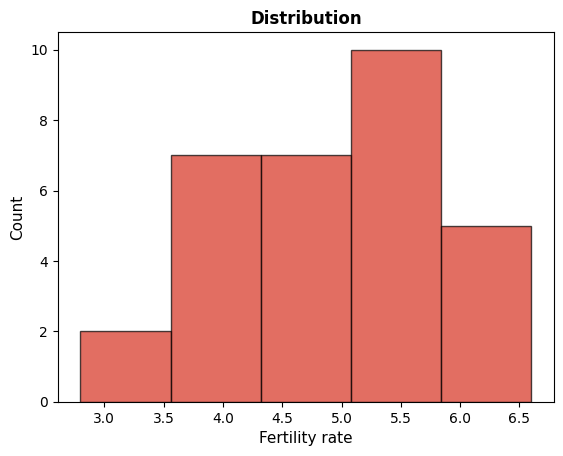

In [5]:
# Histogram
histogram = tz['FEFRTRWTFR'].hist(bins=5, color='#d7301f', alpha=0.7, edgecolor='black')
histogram.set_xlabel('Fertility rate', fontsize=11)
histogram.set_ylabel('Count', fontsize=11)
histogram.set_title('Distribution', fontsize=12, fontweight='bold')
histogram.grid(False)
plt.show()

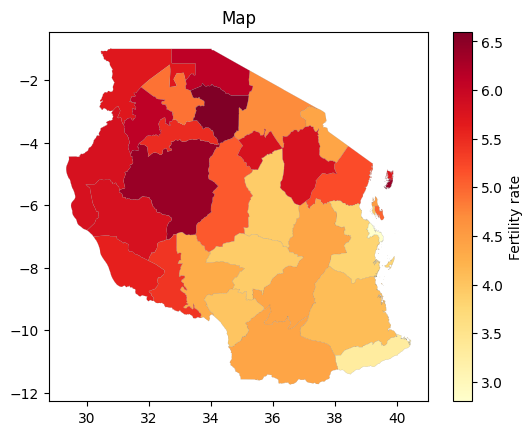

In [6]:
# Map
m = tz.plot(column='FEFRTRWTFR', cmap='YlOrRd', linewidth=0.1,
            edgecolor='grey', legend=True,
            legend_kwds={'label': 'Fertility rate', 'orientation': 'vertical'})
m.set_title('Map')
plt.show()

### 3) Construct spatial weights – Queen contiguity

In [7]:
# Queen adjacency (share edge or vertex)
w_queen = Queen.from_dataframe(tz)
w_queen.transform = 'r'

print(f"Number of observations: {w_queen.n}")
print(f"Number of non-zero weights: {w_queen.s0}")
print(f"Average number of neighbors: {w_queen.mean_neighbors:.2f}")

Number of observations: 31
Number of non-zero weights: 31.0
Average number of neighbors: 4.00


### 3b) Visualise the spatial network (nodes + edges)

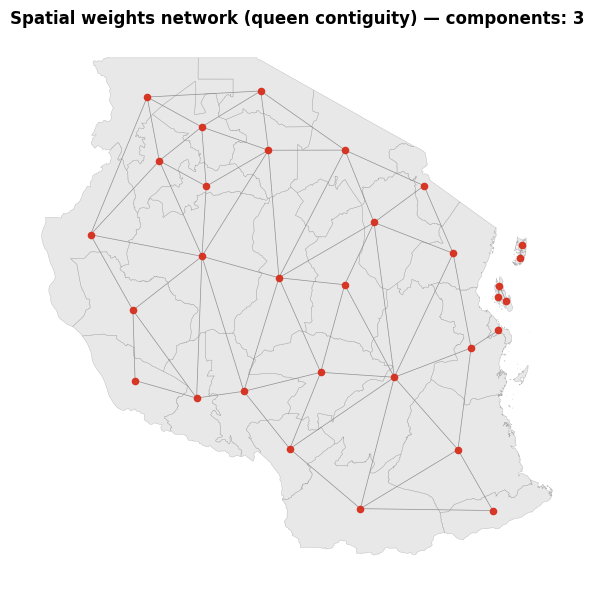

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot polygons
tz.plot(ax=ax, facecolor='lightgrey', edgecolor='grey', linewidth=0.3, alpha=0.5)

# Plot centroids
centroids = tz.centroid
centroids.plot(ax=ax, color='#d7301f', markersize=20, alpha=0.95, zorder=2)

# Plot edges
for idx, neighbors in w_queen.neighbors.items():
    origin = centroids.iloc[idx]
    for neighbor in neighbors:
        if idx < neighbor:  # avoid duplicate edges
            dest = centroids.iloc[neighbor]
            ax.plot([origin.x, dest.x], [origin.y, dest.y],
                   color='grey', linewidth=0.5, alpha=0.85, zorder=1)

# Count connected components
n_components = connected_components(w_queen.sparse, directed=False)[0]

ax.set_title(f'Spatial weights network (queen contiguity) — components: {n_components}',
             fontsize=12, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

### 4) Global Moran's I

In [9]:
# Remove missing values
y = tz['FEFRTRWTFR'].values
valid_idx = np.isfinite(y)
y_clean = y[valid_idx]

# Subset geometry and weights
tz_clean = tz[valid_idx].copy().reset_index(drop=True)
w_clean = Queen.from_dataframe(tz_clean)
w_clean.transform = 'r'

# Global Moran's I
moran_global = Moran(tz_clean['FEFRTRWTFR'], w_clean)

print("="*60)
print("GLOBAL MORAN'S I (PYTHON)")
print("="*60)
print(f"Moran's I: {moran_global.I:.6f}")
print(f"Expected I: {moran_global.EI:.6f}")
print(f"Variance: {moran_global.VI_norm:.6e}")
print(f"Z-score: {moran_global.z_norm:.6f}")
print(f"P-value (two-sided): {moran_global.p_norm:.6f}")
print(f"P-value (simulation, {moran_global.permutations} permutations): {moran_global.p_sim:.6f}")
print("="*60)

GLOBAL MORAN'S I (PYTHON)
Moran's I: 0.558386
Expected I: -0.033333
Variance: 1.855839e-02
Z-score: 4.343554
P-value (two-sided): 0.000014
P-value (simulation, 999 permutations): 0.001000


### 5) Local Moran's I (LISA) and cluster classification

In [10]:
# Local Moran's I
lisa = Moran_Local(tz_clean['FEFRTRWTFR'], w_clean, permutations=999)

# Add LISA statistics to dataframe
tz_clean['lisa_I'] = lisa.Is
tz_clean['lisa_z'] = lisa.z_sim
tz_clean['lisa_p'] = lisa.p_sim
tz_clean['lisa_q'] = lisa.q  # quadrant: 1=HH, 2=LH, 3=LL, 4=HL

# Classify clusters (significance level α = 0.05)
alpha = 0.05
sig = lisa.p_sim <= alpha

# Map quadrants to cluster labels
cluster_labels = {1: 'High-High', 2: 'Low-High', 3: 'Low-Low', 4: 'High-Low', 0: 'Not significant'}
tz_clean['lisa_cluster'] = lisa.q
tz_clean.loc[~sig, 'lisa_cluster'] = 0
tz_clean['lisa_cluster_label'] = tz_clean['lisa_cluster'].map(cluster_labels)

print("\nLISA Cluster Distribution:")
print(tz_clean['lisa_cluster_label'].value_counts())
print(f"\nNumber of significant clusters (α={alpha}): {sig.sum()}")


LISA Cluster Distribution:
lisa_cluster_label
Not significant    18
High-High           7
Low-Low             5
Low-High            1
Name: count, dtype: int64

Number of significant clusters (α=0.05): 13


### 6) Moran scatterplot and LISA cluster map

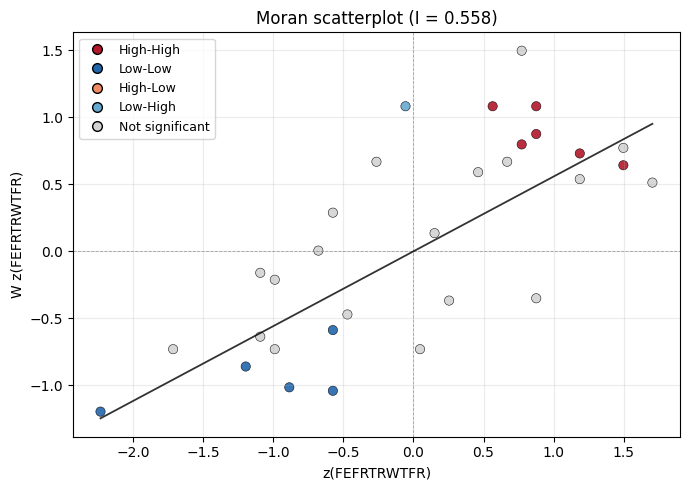

In [11]:
var = "FEFRTRWTFR"
alpha = 0.05

# --- LISA + columns ---
z  = zscore(tz_clean[var].to_numpy())
wz = w_clean.sparse.dot(z)

moran_g = Moran(z, w_clean)
lisa    = Moran_Local(z, w_clean)

sig = lisa.p_sim < alpha

labels = np.select(
    [sig & (lisa.q == 1), sig & (lisa.q == 2), sig & (lisa.q == 3), sig & (lisa.q == 4)],
    ["High-High",         "Low-High",         "Low-Low",          "High-Low"],
    default="Not significant"
)

tz_clean = tz_clean.assign(
    z=z, wz=wz,
    lisa_I=lisa.Is,
    lisa_p=lisa.p_sim,
    lisa_cluster=labels
)

# --- Scatterplot ---
color_map = {
    "High-High": "#B2182B",
    "Low-Low": "#2166AC",
    "High-Low": "#EF8A62",
    "Low-High": "#67A9CF",
    "Not significant": "lightgrey",
}
point_colors = tz_clean["lisa_cluster"].map(color_map).fillna("lightgrey")

c = tz_clean["lisa_cluster"].map(color_map).fillna("lightgrey")

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(tz_clean["z"], tz_clean["wz"], c=c, s=45, alpha=0.9,
           edgecolors="black", linewidths=0.4)

ax.axhline(0, color="grey", lw=0.6, ls="--", alpha=0.7)
ax.axvline(0, color="grey", lw=0.6, ls="--", alpha=0.7)

x = np.array([z.min(), z.max()])
ax.plot(x, moran_g.I * x, "k-", lw=1.3, alpha=0.8)

ax.set(xlabel=f"z({var})", ylabel=f"W z({var})",
       title=f"Moran scatterplot (I = {moran_g.I:.3f})")
ax.grid(alpha=0.25)

handles = [Line2D([0],[0], marker="o", color="w", label=k,
                  markerfacecolor=v, markeredgecolor="black", markersize=7)
           for k, v in color_map.items()]
ax.legend(handles=handles, fontsize=9)

plt.tight_layout()
plt.show()

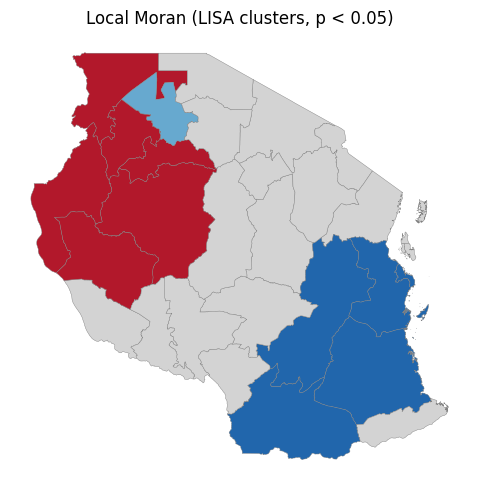

In [12]:

# -----------------------------
# 3) Plot 2: LISA cluster map
# -----------------------------
fig, ax = plt.subplots(figsize=(7, 5))
tz_clean.plot(
    ax=ax,
    color=point_colors,
    edgecolor="grey",
    linewidth=0.3
)
ax.set_title("Local Moran (LISA clusters, p < 0.05)")
ax.set_axis_off()
plt.tight_layout()
plt.show()